<a href="https://colab.research.google.com/github/Mainakdeb/Wine_Quality_Prediction/blob/master/Wine_Connoisseur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange

# Constants

In [2]:
USE_MPS_GPU = False  # device whether to use MPS gpu if available

# connect to GPU if available

In [3]:
import platform

platform.platform()

'macOS-12.6-arm64-arm-64bit'

In [4]:
if torch.has_mps and USE_MPS_GPU:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cpu')

In [5]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

if torch.backends.mps.is_available() and USE_MPS_GPU:
    torch.backends.mps.manual_seed(42)
    torch.backends.mps.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

### The Data :

In [6]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Convert all values into float:

In [7]:
df = df.astype(float)

### Scale all values :

In [8]:
quality_backup = df["quality"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['quality'] = quality_backup #restore quality values

In [9]:
df_scaled.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,0.293730,0.194354,0.201320,0.088825,0.109117,0.116056,0.300141,0.133360,0.425697,0.313775,0.405527,5.877909
std,0.081141,0.098818,0.072903,0.077792,0.064831,0.059258,0.098603,0.057662,0.137273,0.132704,0.198487,0.885639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.240385,0.127451,0.162651,0.016871,0.080119,0.073171,0.229698,0.088924,0.336364,0.220930,0.241935,5.000000
50%,0.288462,0.176471,0.192771,0.070552,0.100890,0.111498,0.290023,0.127820,0.418182,0.290698,0.387097,6.000000
75%,0.336538,0.235294,0.234940,0.142638,0.121662,0.153310,0.366589,0.173318,0.509091,0.383721,0.548387,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


### Balance Data :

In [10]:
# df3['quality'].value_counts().sort_index().plot(kind='bar', sort_columns=False)

In [11]:
# max_size = df_scaled['quality'].value_counts().max()
# lst = [df_scaled]
# for class_index, group in df_scaled.groupby('quality'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# frame_new = pd.concat(lst)
# df_scaled2=frame_new
# df_scaled2["quality"].value_counts()

### Shuffle Data :

In [12]:
# df_scaled3=df_scaled2.sample(frac=1)
# df_scaled3 = df_scaled

### Split into train, test and val set :

In [13]:
train = df_scaled.iloc[:3686]
val = df_scaled.iloc[3686:3886]
test = df_scaled.iloc[3886:]

In [14]:
# train=df.sample(frac=0.8,random_state=23) #random state is a seed value
# test=df.drop(train.index)

### Split features and labels :

In [15]:
X_train, y_train= train.drop('quality', axis=1), train['quality']
print(X_train.shape)

X_val, y_val = val.drop('quality', axis=1), val['quality']
print(X_val.shape)

X_test, y_test = test.drop("quality", axis=1), test["quality"]
print(X_test.shape)

(3686, 11)
(200, 11)
(1012, 11)


### Split into batches :

In [16]:
# train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [17]:
f=20 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 185


/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


### The Model :

In [18]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 44)
        self.fc3 = nn.Linear(44, 88)
        self.fc4 = nn.Linear(88, 176)
        self.fc5 = nn.Linear(176, 88)
        self.fc6 = nn.Linear(88, 22)
        self.fc7 = nn.Linear(22, 1)

        self.dropout = nn.Dropout(0.20)
       
    def forward(self, x):
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=15) 
total_epochs=0

### The training loop :

In [19]:
#print(model)
epochs = 1000
total_epochs+=epochs

model.train()

for e in tnrange(epochs):
    
    train_loss = 0
    val_loss_1 = 0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
    val_loss_divided = val_loss_sum/len(val_batch)
    if not best_val_loss or val_loss_divided > best_val_loss:
        best_val_loss = val_loss_divided
        torch.save(model.state_dict, "best_model.tar")
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_divided)    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

/var/folders/v7/7b5vyv797kg9pf47h5zx_wxr0000gn/T/ipykernel_59637/410710079.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for e in tnrange(epochs):


  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'best_val_loss' is not defined

### Training Metrics :

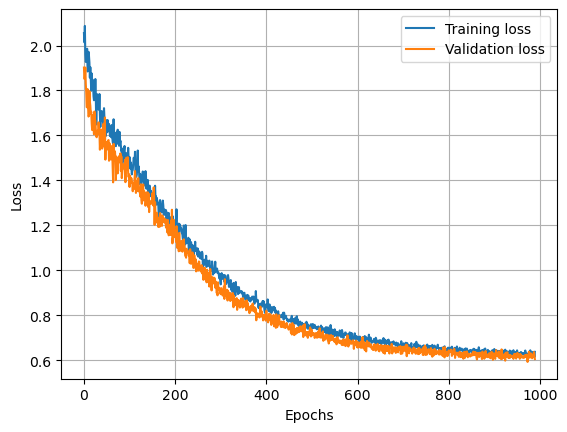

In [ ]:
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### How does the model perform on the test-set?

In [ ]:
model.eval()
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            #print(round(x.item()))
            res.append(round(x.item()))

true_labels= list(test["quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100*(correct/len(res)), "%")

Accuracy: 59.980237154150196 %
